In [12]:
import locator
from locator import Locator, plot_predictions, plot_error_summary
import numpy as np, pandas as pd

# Running Locator with sample weights

In [13]:
# setup locator config
locator = Locator(
    {
        "out": "windows",
        "sample_data": "../data/test_sample_data.txt",
        "zarr": "../data/test_genotypes.zarr",
        "train_split": 0.9,
        "batch_size": 64,
        "keras_verbose": 0,
    }
)

# Load and sort data
genotypes, samples = locator.load_genotypes(
    vcf="../data/test_genotypes.vcf.gz",
    #zarr="../data/test_genotypes.zarr",
)

No GPU devices available. Running on CPU.
reading VCF


[read_vcf] 11527 rows in 0.24s; chunk in 0.24s (48308 rows/s)
[read_vcf] all done (48235 rows/s)


By default, `weight_samples` is `False` and all samples contribute equally to the loss function.

{'enabled': False, 'flip_rate': 0.05}
Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


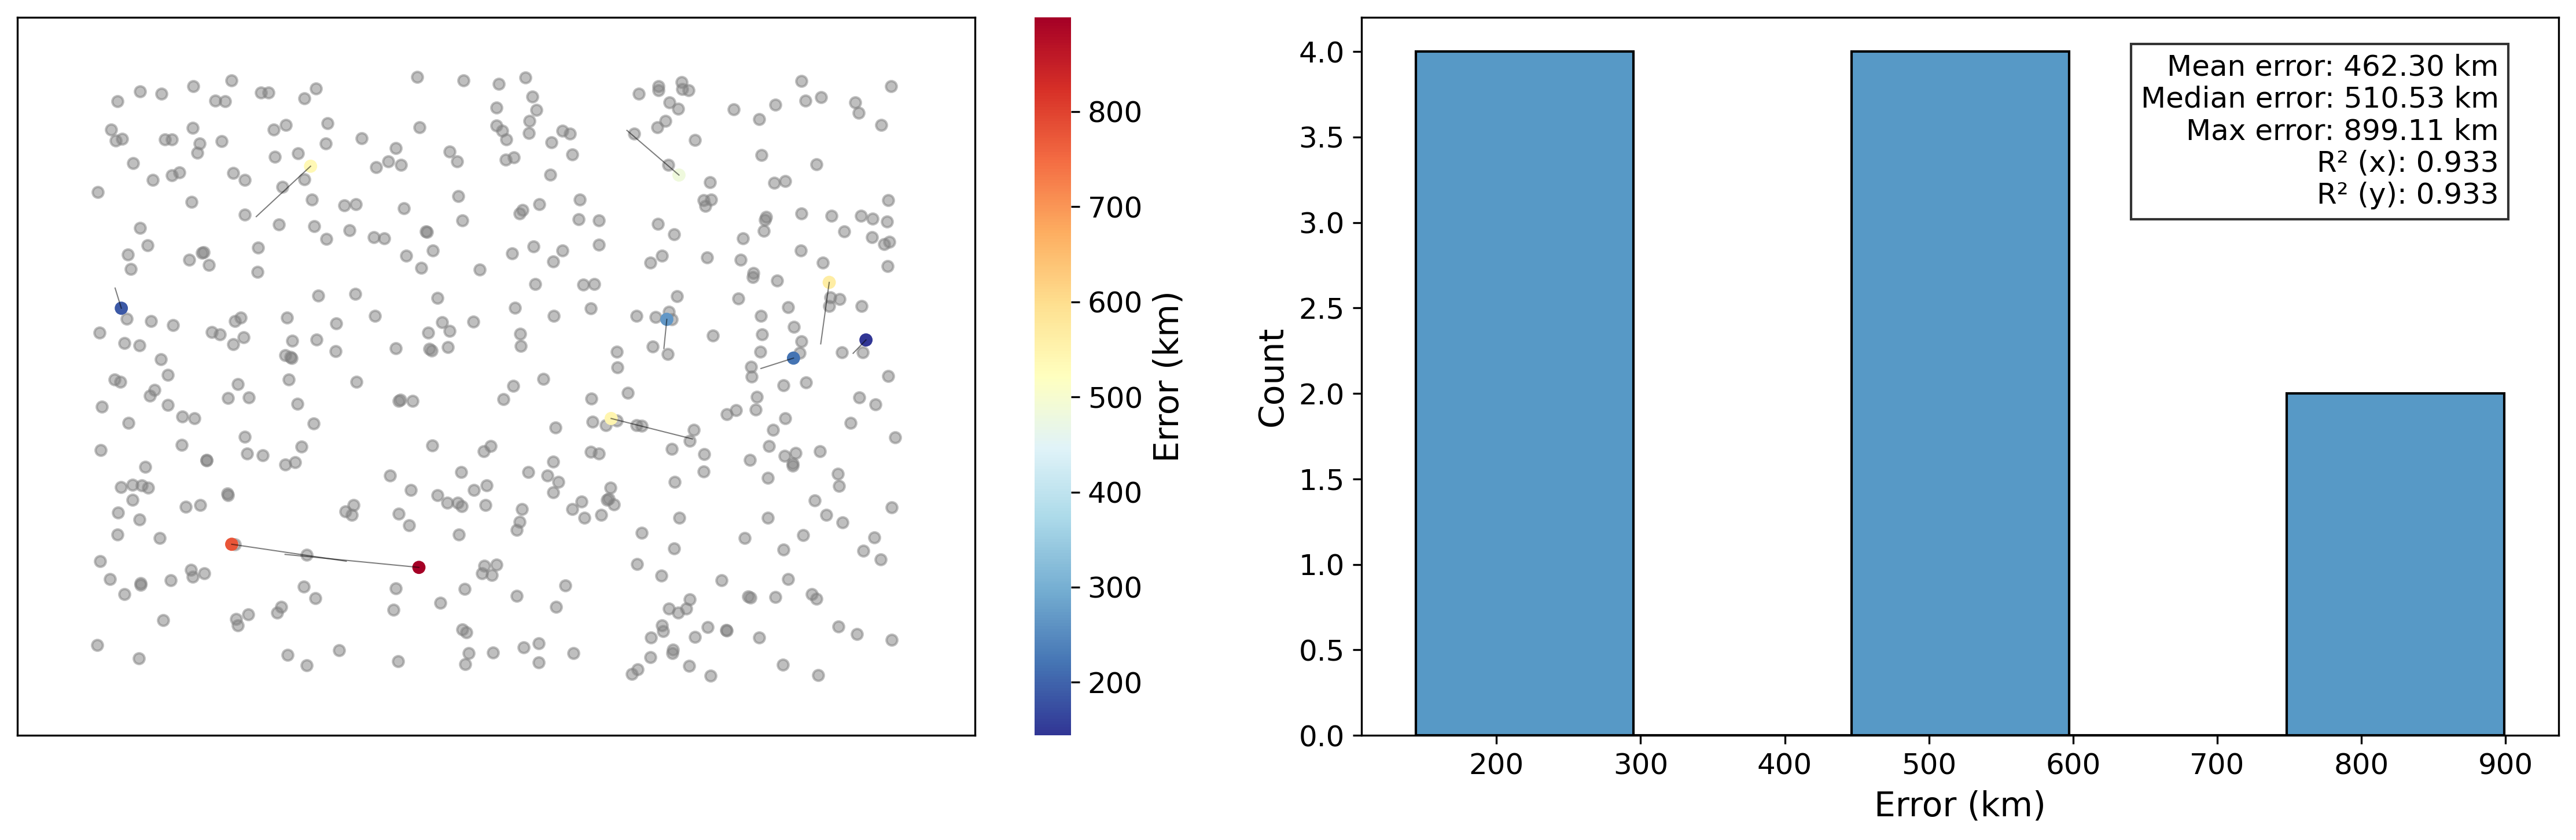

In [14]:
# choose 10 random samples to holdout for all runs
mask = ~np.isnan(locator.sample_data.x.values)
idxs = np.random.choice(np.arange(len(locator.sample_data))[mask], 10)
# run locator with holdout
locator.train_holdout(genotypes, samples, holdout_indices=idxs)
predictions = locator.predict_holdout(return_df=True, plot_map=False)

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

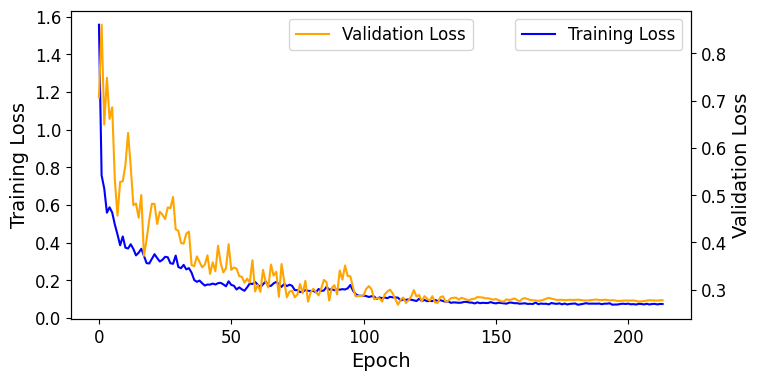

In [15]:
locator

To weight each sample's contribution to the loss function during training, we can use the `weight_samples()` function from `locator.utils`.

`weight_samples()` requires three arguments: a method (either `"KD"`, `"histogram"`, or `"load"`), the locations of training samples, and the IDs of training samples. It returns a dictionary of `sample_weights` that we pass to the `locator` object using the `.set_sample_weights()` method.

We'll use `plot_sample_weights` to visualize how the training samples are being weighted.

In [16]:
from locator.utils import weight_samples
from locator import  plot_sample_weights

To illustrate how this works, let's calculate sample weights using the `"histogram"` method:

/Users/clararehmann/phd/research/ReLocator/locator/core.py:1355: UserWarning: Sample weights already calculated. 
                    Set locator.sample_weights to None in config to disable.
  warnings.warn(


{'enabled': False, 'flip_rate': 0.05}


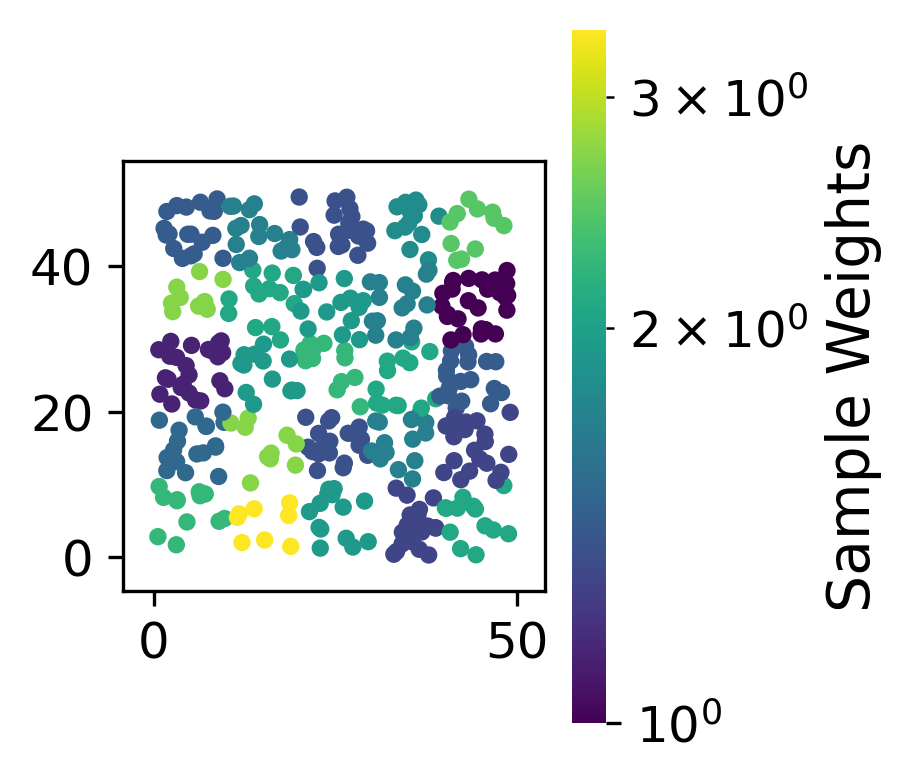

Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


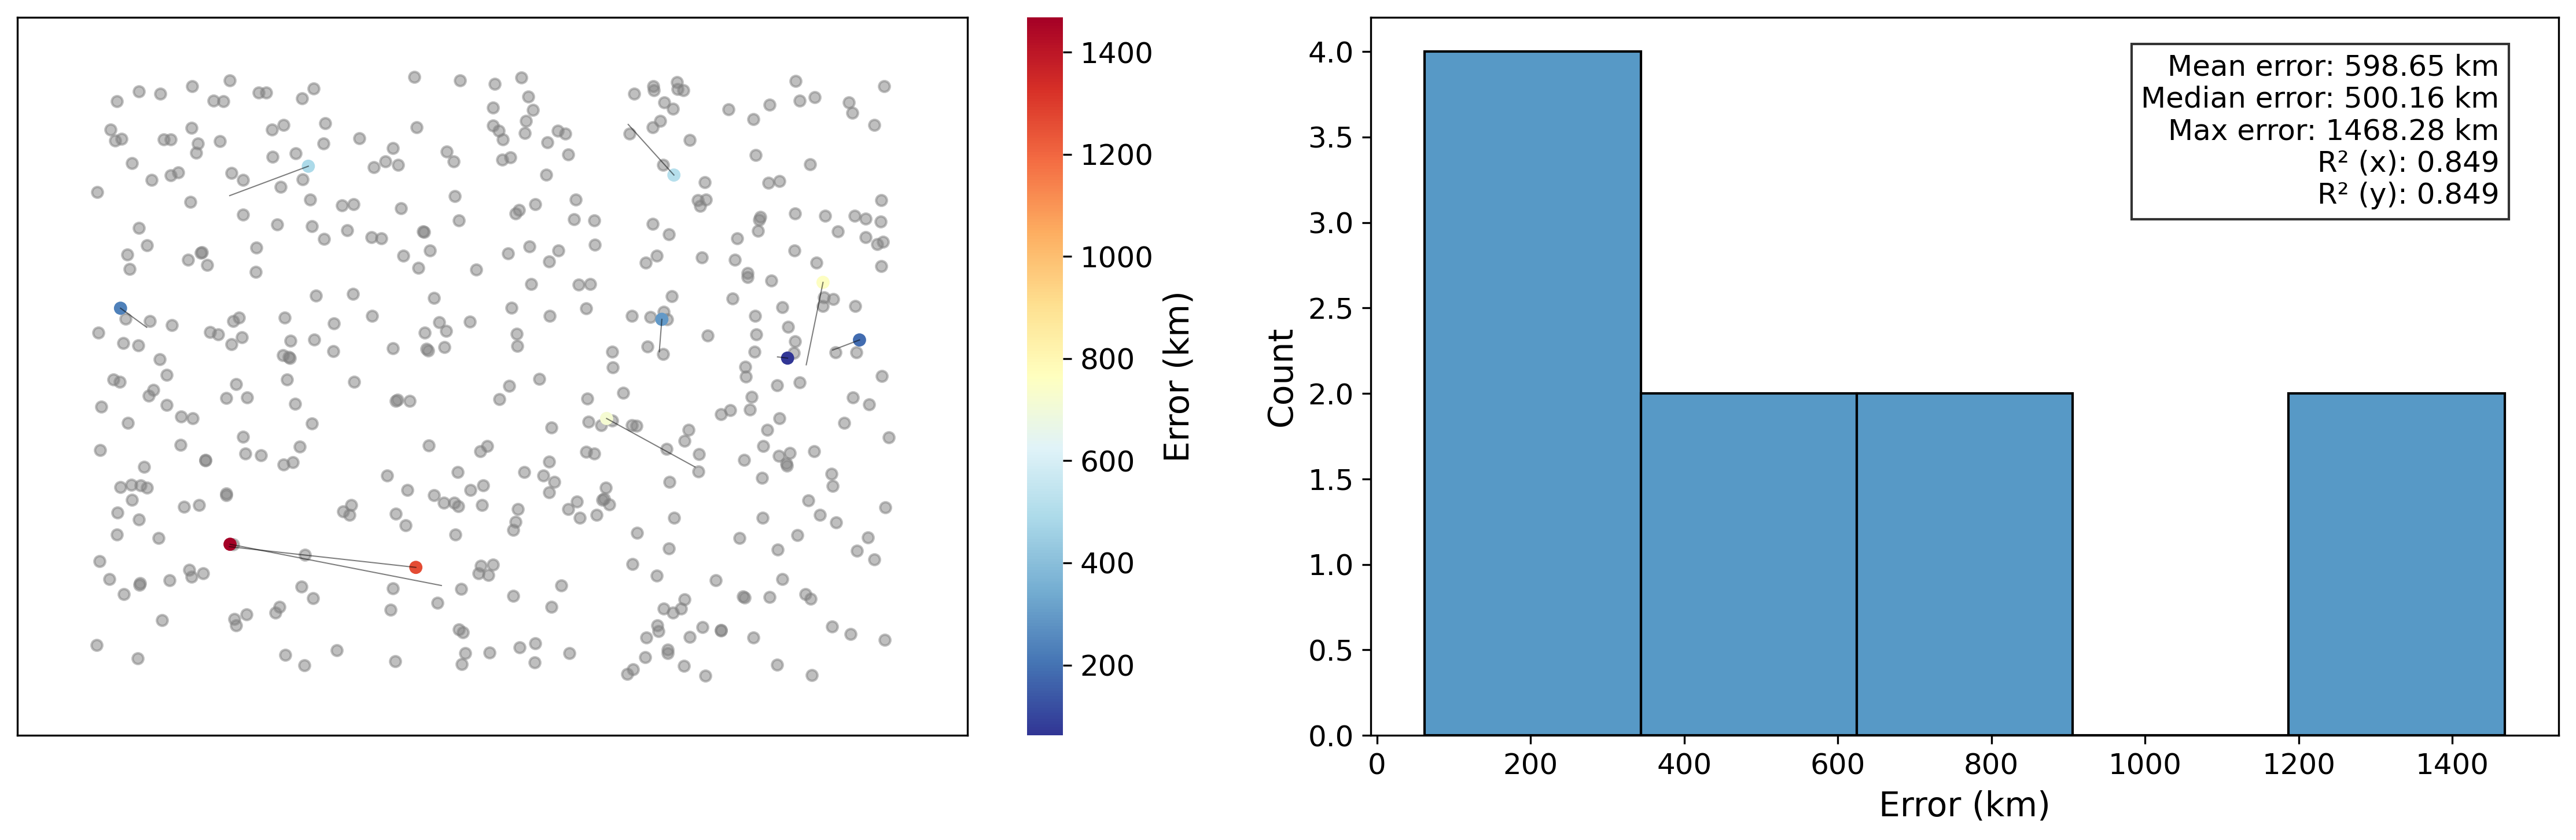

In [17]:
sample_weights = weight_samples(
    method="histogram",
    trainlocs=locator.unnormedlocs,
    trainsamps=locator.trainIDs,
    xbins=5,
    ybins=5
)
locator.set_sample_weights(sample_weights)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)#k=10)
plot_sample_weights(locator, plot_map=False)
predictions = locator.predict_holdout(return_df=True, plot_map=False)


Now, we can see that our model's configuration has been updated to include our sample weighting parameters:

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

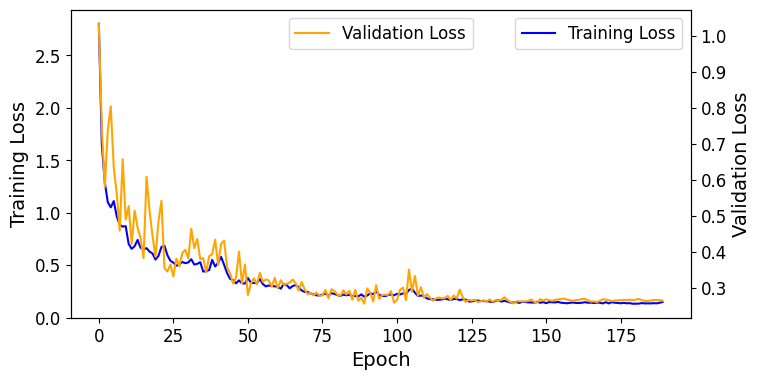

In [18]:
locator


We can also use a more fine-tuned method like kernel density weighting:

/Users/clararehmann/phd/research/ReLocator/locator/core.py:1355: UserWarning: Sample weights already calculated. 
                    Set locator.sample_weights to None in config to disable.
  warnings.warn(


{'enabled': False, 'flip_rate': 0.05}


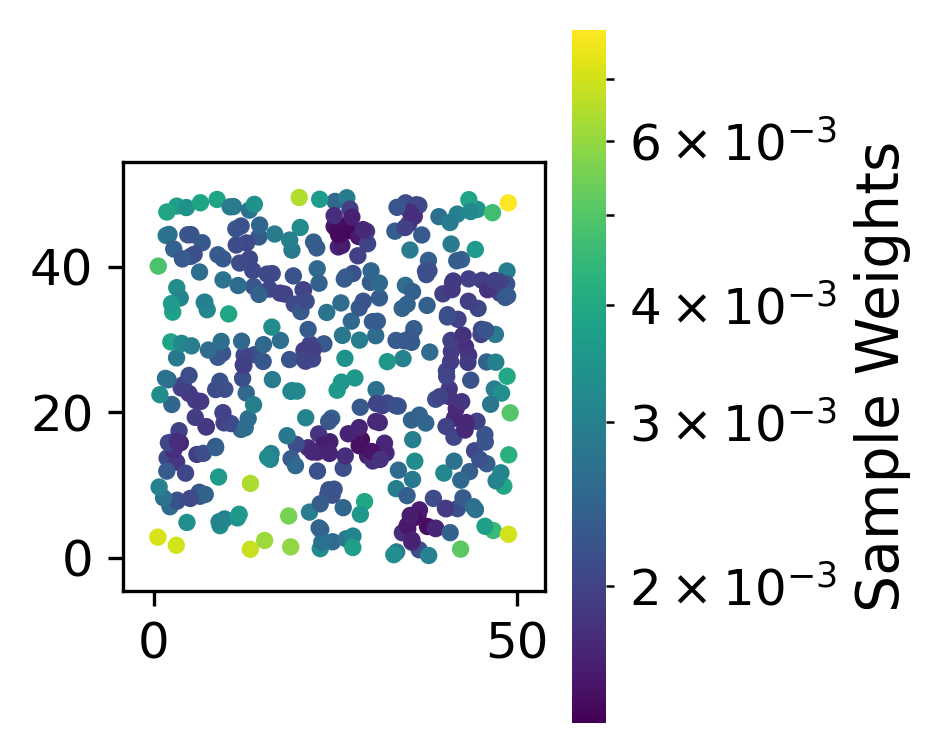

Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


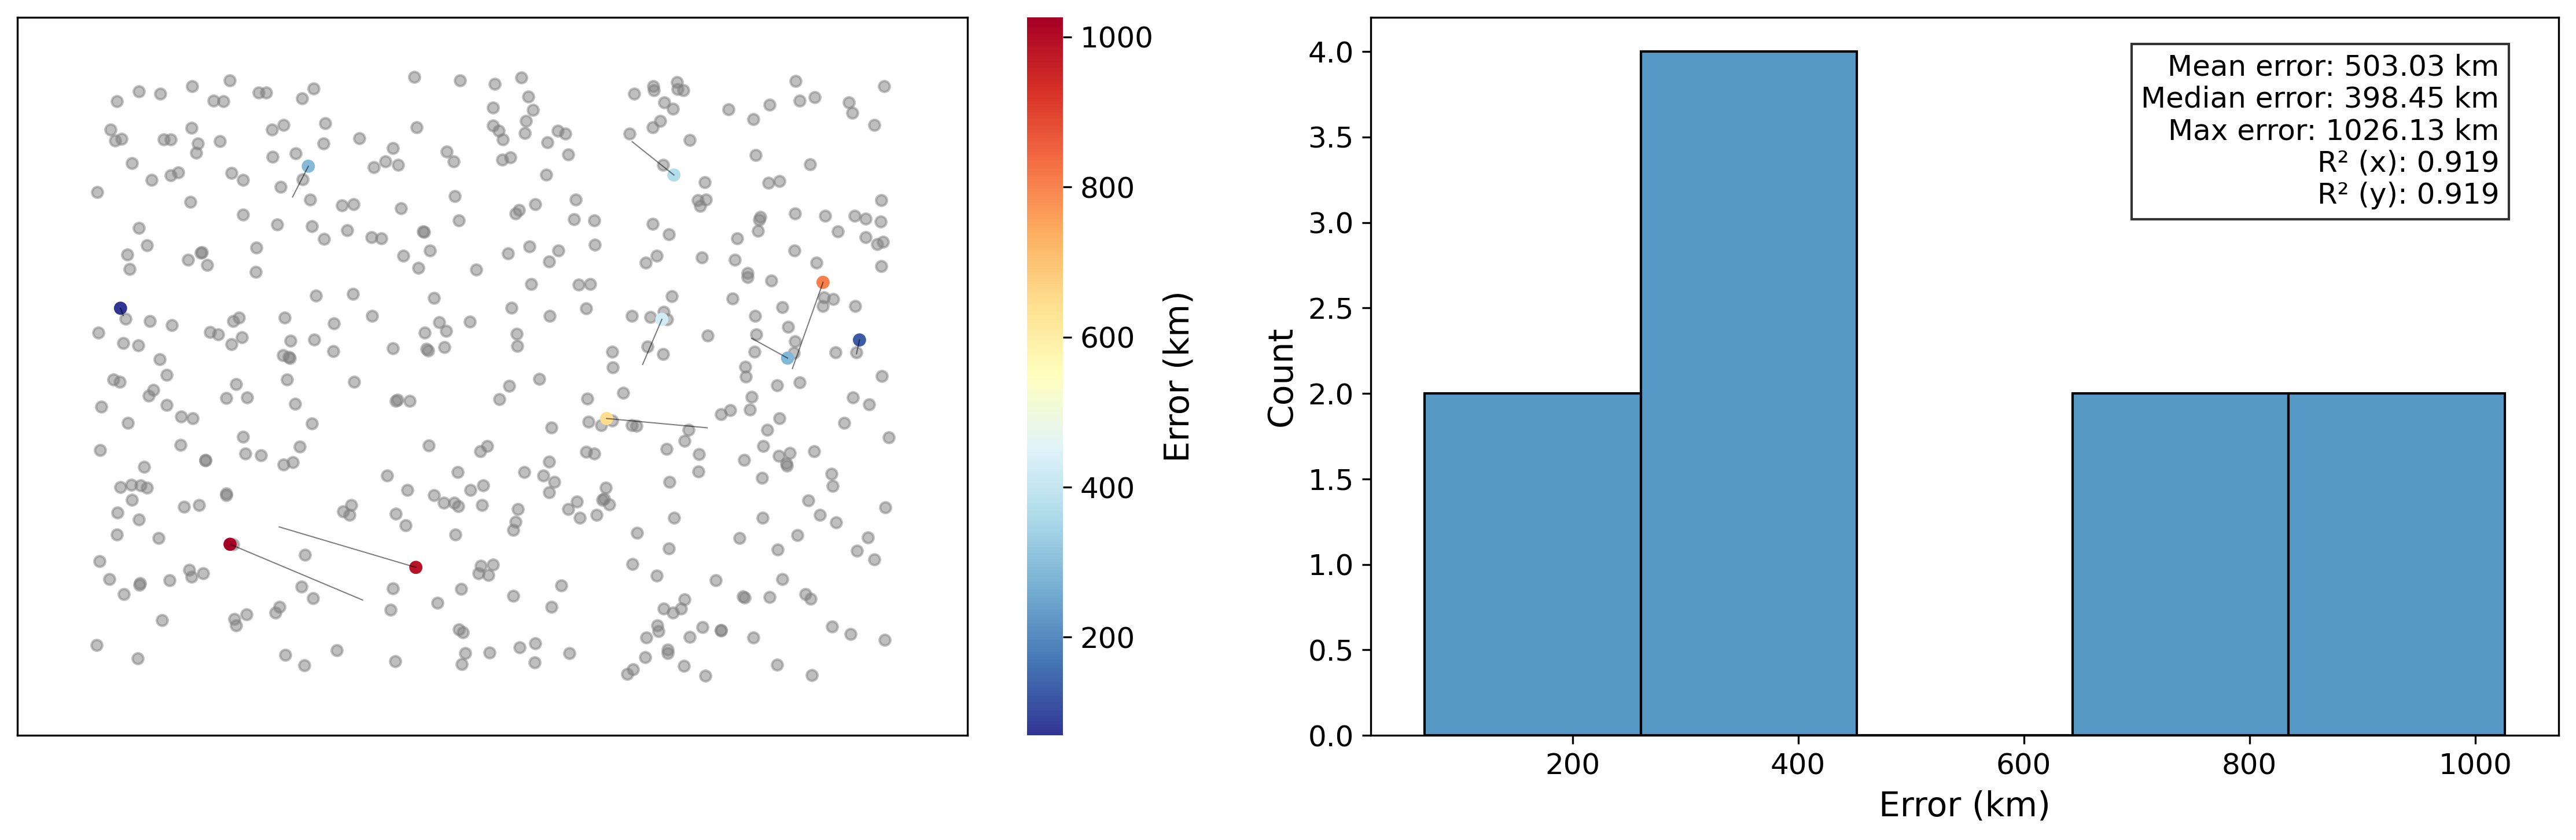

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

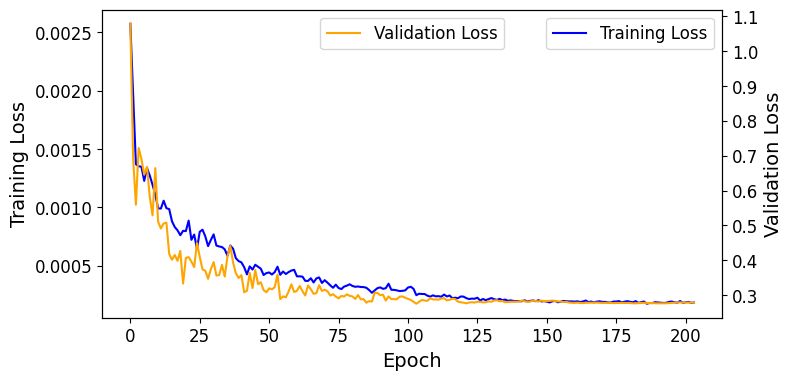

In [19]:
sample_weights = weight_samples(
    method="KD",
    trainlocs=locator.unnormedlocs,
    trainsamps=locator.trainIDs,
)
locator.set_sample_weights(sample_weights)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)#k=10)
plot_sample_weights(locator, plot_map=False)
predictions = locator.predict_holdout(return_df=True, plot_map=False)
locator


Finally, if you want to set your own sample weights manually, you can pass a DataFrame to `weight_samples` using the method `"load"`:

In [20]:
tdf = pd.DataFrame({'sampleID':locator.trainIDs,
                    'sample_weight':np.random.choice([0.1, 1], size=len(locator.trainIDs))})

/Users/clararehmann/phd/research/ReLocator/locator/core.py:1355: UserWarning: Sample weights already calculated. 
                    Set locator.sample_weights to None in config to disable.
  warnings.warn(


{'enabled': False, 'flip_rate': 0.05}


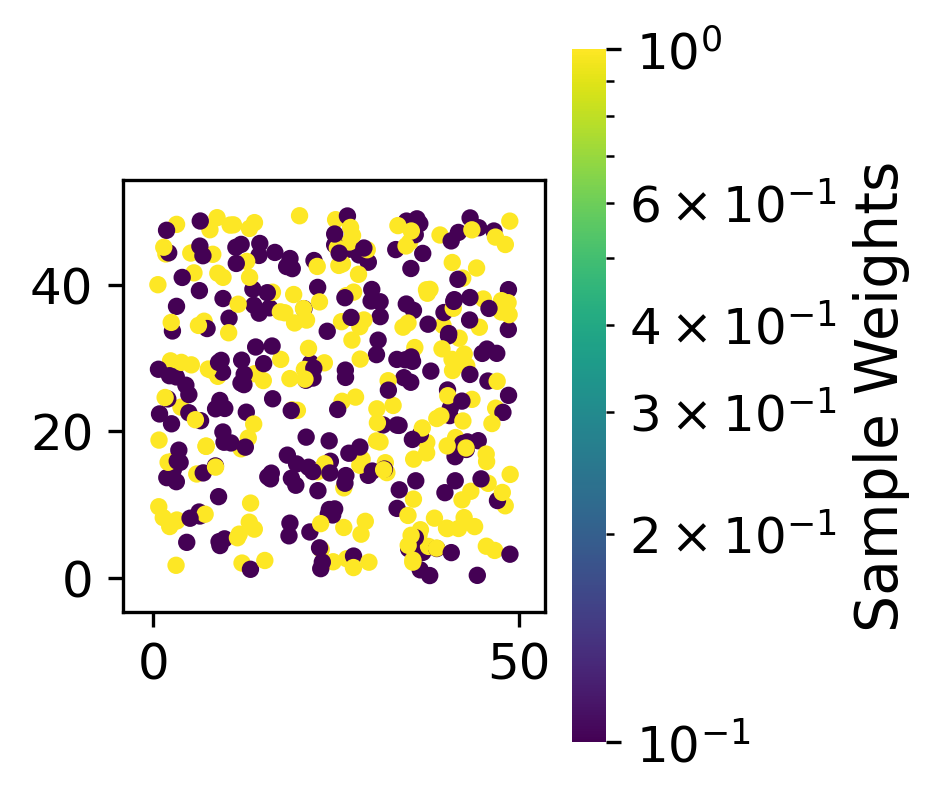

Predicting locations for holdout samples...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


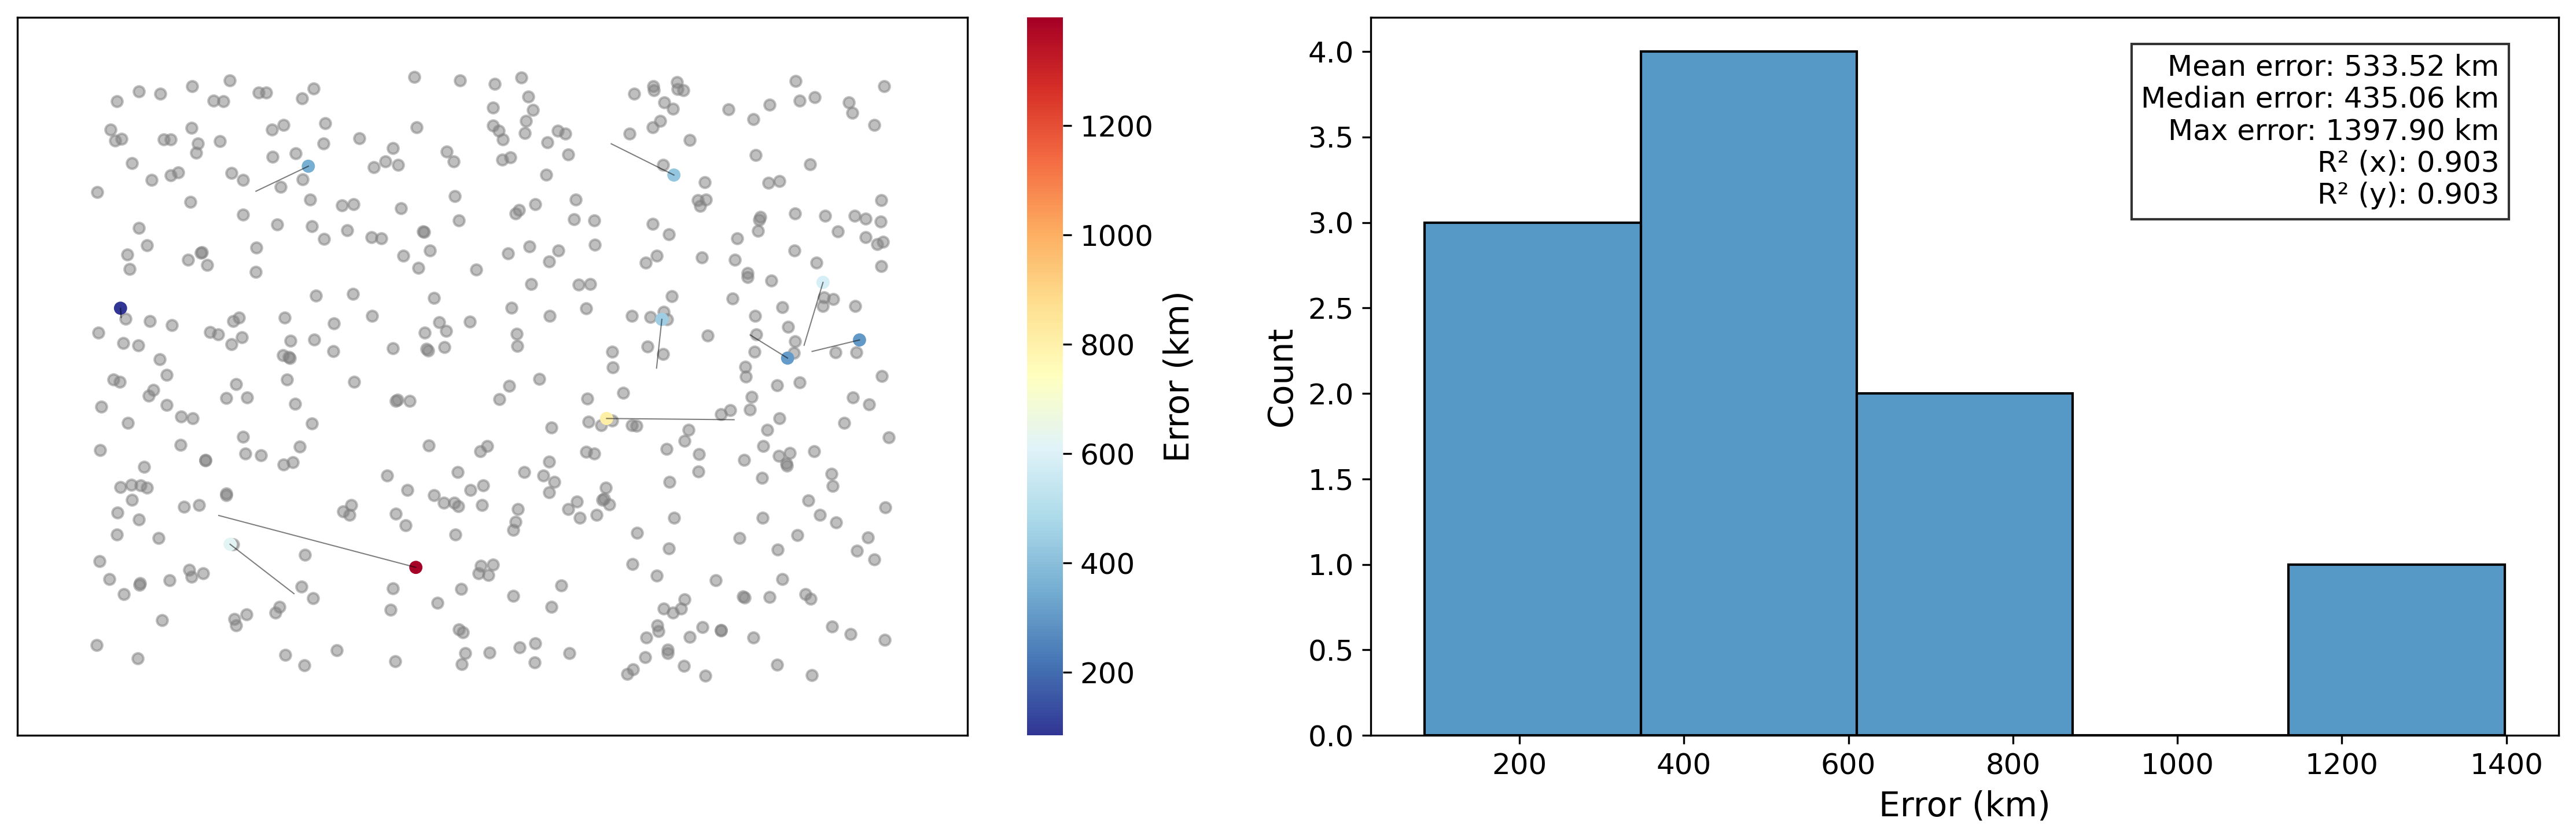

Configuration,Value
train_split,0.9
batch_size,64
min_mac,2
max_SNPs,None
width,256
nlayers,8
dropout_prop,0.25
max_epochs,5000
optimizer_algo,adam
learning_rate,0.001

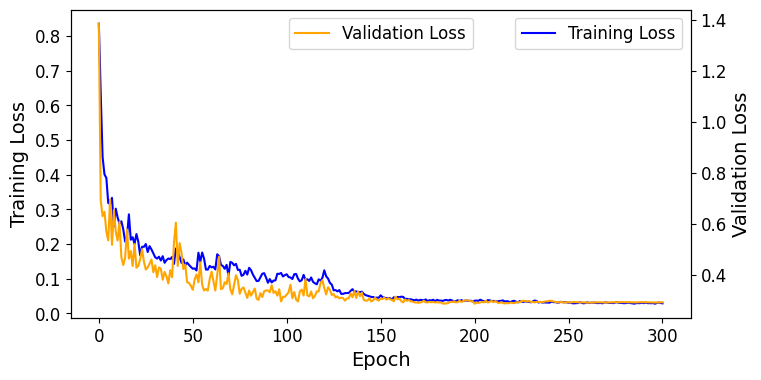

In [21]:
sample_weights = weight_samples(
    method="load",
    weightdf=tdf,
    trainsamps=locator.trainIDs,
)
locator.set_sample_weights(sample_weights)
locator.train_holdout(genotypes, samples, holdout_indices=idxs)
plot_sample_weights(locator, plot_map=False)
predictions = locator.predict_holdout(return_df=True, plot_map=False)
locator


In [22]:
predictions

,x,y,sampleID,x_pred,y_pred,distance
0,8.037035,13.457247,msp_300,8.037035,13.457247,0.0
1,12.640863,7.025532,msp_163,12.640863,7.025532,0.0
2,43.843018,27.465050,msp_211,43.843018,27.465050,0.0
3,10.311729,40.132210,msp_71,10.311729,40.132210,0.0
4,44.330647,26.952660,msp_83,44.330647,26.952660,0.0
5,39.561337,21.336224,msp_93,39.561337,21.336224,0.0
6,40.544193,28.310677,msp_204,40.544193,28.310677,0.0
7,34.816334,25.581638,msp_402,34.816334,25.581638,0.0
8,32.044598,44.034470,msp_350,32.044598,44.034470,0.0
9,2.065878,29.743158,msp_135,2.065878,29.743158,0.0
